#  Bagging
This notebook implements bagging forecasts using the autoarima package that implements sarimax models.

In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL


# adiciona a pasta src ao sys.path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# Importa o script paths de utils para geracão de caminhos absolutos
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition, process_df, block_bootstrap_stl_residuals, fit_sarima_on_simulations_long
from utils.model_metrics import rmse, mae, mape

# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="pastel",
    context="notebook"
)


reads the arrivals dataset

In [3]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH, covid_dummy=True)
df = arrivals_dataset.get_data_without_missing_values()

Ajeitando nivel de agregacão

In [4]:
agg_cols = ["date","continent","continent_id", "year", "month", "month_id"]
value_cols = ["arrivals", "covid_dummy"]
df_rj = process_df(df=df, state="rio_de_janeiro", agg_cols=agg_cols, value_cols=value_cols, agg_func=np.sum)

/home/renan/academico/series_temporais/src/utils/calculations.py:110: FutureWarning: The provided callable <function sum at 0x7f1b093acb80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  return df.groupby(agg_cols)[value_cols].agg(agg_func).reset_index()


Ajeitando a dummy da covid para o nivel de agregacao

In [5]:
# adjust covid dummy
df_rj["covid_dummy"] = df_rj["covid_dummy"].apply(lambda x: 1 if x > 0 else 0)

In [7]:
test_df = df_rj[df_rj["continent"]=="america_do_sul"]
test_df

,date,continent,continent_id,year,month,month_id,arrivals,covid_dummy
3,2000-01-01,america_do_sul,4,2000,janeiro,1,22097.0,0
10,2000-02-01,america_do_sul,4,2000,fevereiro,2,19790.0,0
17,2000-03-01,america_do_sul,4,2000,marco,3,18723.0,0
24,2000-04-01,america_do_sul,4,2000,abril,4,15469.0,0
31,2000-05-01,america_do_sul,4,2000,maio,5,13221.0,0
...,...,...,...,...,...,...,...,...
2068,2024-08-01,america_do_sul,4,2024,agosto,8,48059.0,0
2075,2024-09-01,america_do_sul,4,2024,setembro,9,71341.0,0
2082,2024-10-01,america_do_sul,4,2024,outubro,10,81603.0,0
2089,2024-11-01,america_do_sul,4,2024,novembro,11,78739.0,0


## Usando dados imputados

In [8]:
df_path = os.path.join(PROJECT_ROOT, "notebooks", "modeling", "ets_forecast_TRAIN.csv")
df = pd.read_csv(df_path)
df

,date,continent,actual,ets_forecast,error,abs_error,pct_error,ets_model,model_type,arima_model
0,2000-01-01,America_Do_Norte,22202.0,18082.070165,-4119.929835,4119.929835,-18.556571,"ETS(M,N,M)",AutoETS,NaN
1,2000-02-01,America_Do_Norte,19060.0,19986.541950,926.541950,926.541950,4.861185,"ETS(M,N,M)",AutoETS,NaN
2,2000-03-01,America_Do_Norte,17767.0,19325.610283,1558.610283,1558.610283,8.772501,"ETS(M,N,M)",AutoETS,NaN
3,2000-04-01,America_Do_Norte,14761.0,13363.934207,-1397.065793,1397.065793,-9.464574,"ETS(M,N,M)",AutoETS,NaN
4,2000-05-01,America_Do_Norte,12601.0,12939.110184,338.110184,338.110184,2.683201,"ETS(M,N,M)",AutoETS,NaN
...,...,...,...,...,...,...,...,...,...,...
2299,2023-08-01,TOTAL,80697.0,87601.714505,-6904.714505,6904.714505,-8.556346,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
2300,2023-09-01,TOTAL,82149.0,74041.895005,8107.104995,8107.104995,9.868781,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
2301,2023-10-01,TOTAL,92918.0,88634.817681,4283.182319,4283.182319,4.609637,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
2302,2023-11-01,TOTAL,114550.0,94906.380829,19643.619171,19643.619171,17.148511,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"


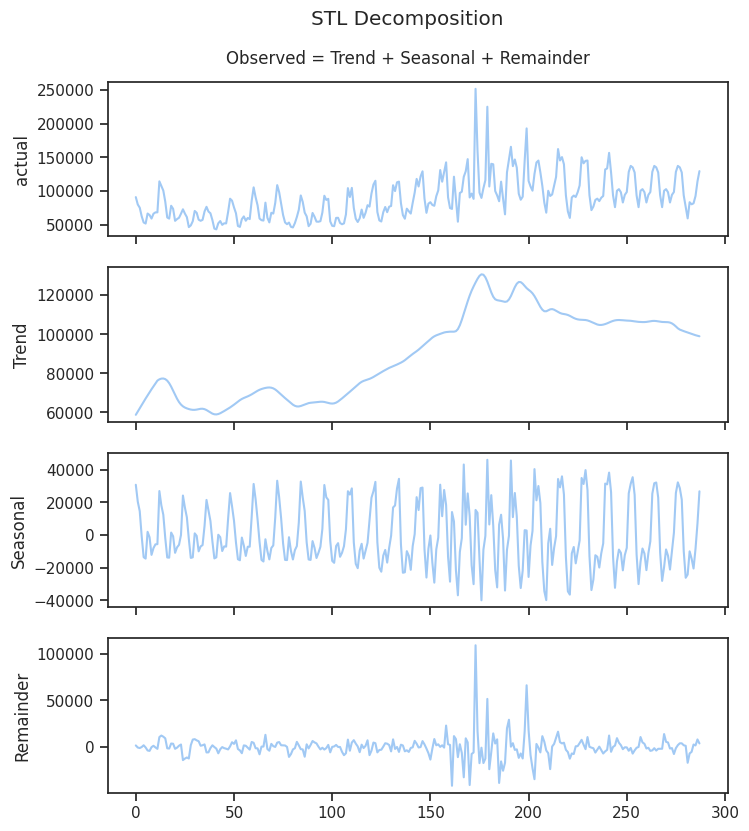

In [9]:
test_df = df[df["continent"] == "TOTAL"]
dcmp = plot_stl_decomposition(
    df=test_df,
    value_col="actual",
    date_col="date",
    log=False
)


In [10]:
sim_df = block_bootstrap_stl_residuals(
    dcmp=dcmp,
    block_size=12,
    simulations=100,
    remainder_col="remainder",
    trend_col="trend",
    seasonal_col="seasonal",
    date_col="ds",
    log=False,
    return_original_scale=False,
    random_state=42
    )

In [65]:
sarima_sims_df = fit_sarima_on_simulations_long(
    sim_df=sim_df,
    h=12,
    date_col="ds",
    simulation_prefix="sim_",
    seasonal=True,
    m=12,
    freq="MS",
    auto_arima_kwargs = dict(
    seasonal=True, m=12,
    max_p=4, max_q=4, max_P=3, max_Q=3,
    max_d=2, max_D=2,
    max_order=8,
    information_criterion="aicc",
    stepwise=True,
    suppress_warnings=True
    ),
    verbose=False
)

100%|██████████| 100/100 [2:18:46<00:00, 83.26s/it]  


In [66]:
sarima_sims_df.to_csv("sarima_bagging_total.csv", index=False)

In [2]:
sarima_sims_df = pd.read_csv("sarima_bagging_total.csv")

In [3]:
plotter = Plotter()

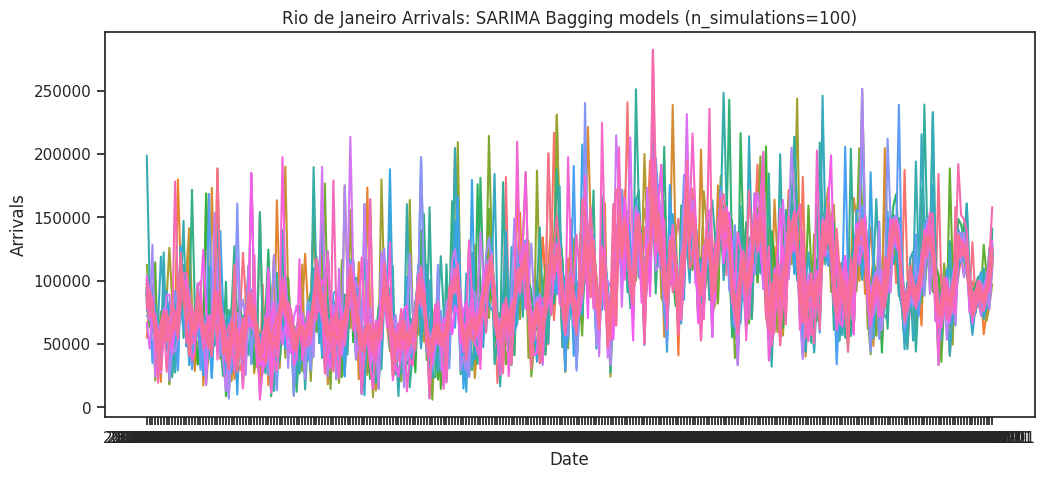

In [4]:
fig, ax = plt.subplots(figsize=(12,5))
plotter.plot(
    data=sarima_sims_df,
    plot_name="lineplot",
    ax=ax,
    hue="simulation",
    x="ds",
    y="value",
    legend=False,
    title="Rio de Janeiro Arrivals: SARIMA Bagging models (n_simulations=100)",
    x_label="Date",
    y_label="Arrivals"
    )

plt.show()

### Calculando métricas de ajuste

Importando dados de teste

In [5]:
df_test_path = os.path.join(PROJECT_ROOT, "notebooks", "modeling", "ets_forecasts_TEST.csv")
df_test = pd.read_csv(df_test_path)

In [6]:
sarima_bagging_forecasts = pd.DataFrame(sarima_sims_df.groupby("ds")["value"].mean()).reset_index()
sarima_bagging_forecasts

,ds,value
0,2000-01-01,90219.214338
1,2000-02-01,81419.792559
2,2000-03-01,77613.993147
3,2000-04-01,63245.062215
4,2000-05-01,51422.791951
...,...,...
295,2024-08-01,90322.902799
296,2024-09-01,84970.842213
297,2024-10-01,92825.732078
298,2024-11-01,101861.236064


In [7]:
total_actual_df = df_test[df_test["continent"] == "TOTAL"]
total_actual_df

,date,continent,actual,ets_forecast,error,abs_error,pct_error,ets_model,model_type,arima_model
84,2024-01-01,TOTAL,163598.0,133662.015115,29935.984885,29935.984885,18.298503,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
85,2024-02-01,TOTAL,170305.0,129759.527000,40545.473000,40545.473000,23.807565,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
86,2024-03-01,TOTAL,157683.0,123044.937907,34638.062093,34638.062093,21.966897,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
87,2024-04-01,TOTAL,102172.0,90285.614324,11886.385676,11886.385676,11.633702,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
88,2024-05-01,TOTAL,84116.0,73504.230933,10611.769067,10611.769067,12.615637,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
89,2024-06-01,TOTAL,82402.0,93858.014371,-11456.014371,11456.014371,-13.902593,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
90,2024-07-01,TOTAL,108089.0,96835.956171,11253.043829,11253.043829,10.410906,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
91,2024-08-01,TOTAL,91504.0,92279.277108,-775.277108,775.277108,-0.847260,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
92,2024-09-01,TOTAL,116003.0,78868.542781,37134.457219,37134.457219,32.011635,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"
93,2024-10-01,TOTAL,130985.0,88924.819494,42060.180506,42060.180506,32.110685,"ETS(M,A,M)",HYBRID,"(1, 0, 0, 0, 1, 0, 0)"


In [29]:
left_df = total_actual_df.loc[:, ["date", "continent", "actual"]]
left_df["date"] = pd.to_datetime(left_df["date"])
right_df = sarima_bagging_forecasts
right_df["ds"] = pd.to_datetime(right_df["ds"])
final_df = pd.merge(left=left_df, right=right_df, left_on="date", right_on="ds")
final_df = final_df.drop("ds", axis=1)
final_df = final_df.rename(columns={"value":"forecast"})
final_df.to_csv("bagging_forecasts.csv", index=False)

In [12]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [13]:
rmse(final_df["actual"], final_df["value"])

np.float64(32322.462711122684)

In [14]:
mape(final_df["actual"], final_df["value"])

np.float64(18.39096161643143)

In [15]:
mae(final_df["actual"], final_df["value"])

np.float64(26540.15151530706)